In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_04 import *

## Initial setup

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7013)

In this notebooks we will use what we learned in notebook 04 to do *one-cycle training*. In the coming lessons we will do a deep dive on the dynamics of how models train by using *hooks*. In a nutshell, if you manage to get the first batches working well, everything becomes easier, in the sense that you can get *superconvergence*, and for this good *annealing* is critical. We start as before getting our data, creating a `DataBunch`, a `Learner` and a `Runner`.

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

By default, `get_model()` sets the learning rate to 0.5. This is the definition of `get_model()`.

```python
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh),
                          nn.ReLU(),
                          nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr=lr)
```

In [6]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.6433898828125, tensor(0.8154)]
valid: [0.2967282958984375, tensor(0.9143)]
train: [0.2877551171875, tensor(0.9156)]
valid: [0.2715494873046875, tensor(0.9217)]
train: [0.2320511328125, tensor(0.9326)]
valid: [0.196691357421875, tensor(0.9447)]


We can change it to 0.3, and see how it changes.

In [7]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.7610684375, tensor(0.8069)]
valid: [0.35528291015625, tensor(0.8984)]
train: [0.3481691015625, tensor(0.9007)]
valid: [0.2932612060546875, tensor(0.9151)]
train: [0.3004438671875, tensor(0.9136)]
valid: [0.2782374267578125, tensor(0.9213)]


Let's create a function that returns a model with a given learning rate. `get_model_func()` returns a function that returns a model and an optimizer with the learning rate fixed at the value `lr`.

In [8]:
#export
def get_model_func(lr=0.5):
    return partial(get_model, lr=lr)

## Annealing

We define two new callbacks: the `Recorder` to save track of the loss and our scheduled learning rate, and a `ParamScheduler` that can schedule any hyper-parameter as long as it's registered in the `state_dict` of the optimizer. 

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7202)

We are going to create a callback that does hyper-parameter scheduling. In this notebook we will only look into the learning rate, but in the last 12 months research has focused on scheduling other things, like the dropout rate, weight decay, momentum, what type of data augmentation you use, etc. One observation is that the loss landscape of NNs looks very different at the beginning, in the middle, and at the end of the training process. It is therefore very unlikely that the same hyper-parameters will be equally effective throughout the training loop.

The `Recorder` class allows us to look into the learning rates and the losses at each batch. In general, there will be multiple learning rates, one for each parameter group. In fastai the `Recorder` only stores the learning rate of the final layer. The class also contains plotting functions for visualization.

**CLARIFY**: 

1. Who attaches `lr` to `self.opt.param.groups`?
2. Where is `self.opt` inherited from?

In [9]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = []
        self.losses = []

    def after_batch(self):
        if not self.in_train:
            return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr(self):
        plt.plot(self.lrs)

    def plot_loss(self):
        plt.plot(self.losses)

For the scheduler, we are going to pass the name of a parameter `param` (in our case `lr`) and a scheduling function `sched_func()` to `__init__()`. `sched_func()` takes the current fraction of the total number of epochs and, for each parameter group, it will set the parameter of interest. We don't necessarily want to have the same value of a hyper-parameter, in this case the learning rate, for all our layers. This is why we use the parameter groups (abstracted to *layer groups* in fastai, but pretty much the same thing). Parameter groups are contained in the *optimizer*. A PyTorch optimizer usually contains only one parameter group, unless specified otherwise.

Every time we start a new batch (`begin_batch()`) we call `set_param()`.

In [10]:
class ParamScheduler(Callback):
    _order = 1

    def __init__(self, pname, sched_func):
        self.pname = pname
        self.sched_func = sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs / self.epochs)

    def begin_batch(self):
        if self.in_train:
            self.set_param()

As we said before, `sched_func` takes the fraction `pos` (for *position*) of the total number of epochs, so a number between 0 and 1.
Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion. Note that `pos` is a number between 0 and 1, but `start` and `end` are the initial and the final learning rates. The `_inner` function takes `start`, `end` and `pos` and returns the scheduled learning rate at position `pos`. To convert `_inner` into a function that only takes `pos` we again use `partial`.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7431)

In [11]:
def sched_lin(start, end):
    def _inner(start, end, pos):
        return start + pos * (end - start)
    return partial(_inner, start, end)

The above solution works fine, but since we are going to use many schedulers, we don't want to rewrite this function every time. We can therefore it refactor with a **decorator**.

How does the decorator work? Since `sched_lin()` has an `@annealer` decorator, it is passed as an argument to the decorator function `annealer`, and the definition of `sched_lin` is replaced with whatever `anneal` returns, in this case `_inner`.

With this trick, we can define `sched_lin()` in the natural way, taking `start`, `end`, `pos`. The `@annealer` decorator then takes `sched_lin()` and returns a function of `pos` only.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7526)

In [12]:
#export
def annealer(f):
    def _inner(start, end):
        return partial(f, start, end)
    return _inner


@annealer
def sched_lin(start, end, pos):
    return start + pos * (end - start)

In [13]:
# shift-tab works too, in Jupyter!
# It works in Emacs too!!!
# sched_lin()

In the code below, `f = f(pos)`.

In [14]:
f = sched_lin(1, 2)
f(0.3)

1.3

We can now define many other schedulers. For example, a "non-scheduler" `sched_no()` that always returns the `start` value, a cosine scheduler, an exponential scheduler and, more interesting to us, a *cosine one-cycle scheduler*.

It is not possible to directly plot `torch.Tensors`, but it turns out that the only reason is that they don't have an `ndim` attribute. The rather dirty workaround in the last line below, adds it.

You can read more about `property` [here](https://docs.python.org/3/library/functions.html#property) and more in general [here](https://docs.python.org/3/howto/descriptor.html).

In [15]:
#export
@annealer
def sched_cos(start, end, pos):
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2


@annealer
def sched_no(start, end, pos):
    return start


@annealer
def sched_exp(start, end, pos):
    return start * (end / start) ** pos


def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]


# This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7730)

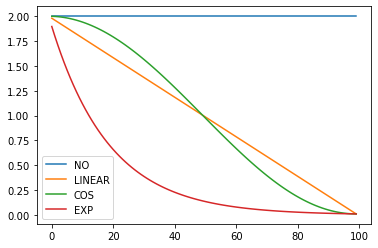

In [16]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

It has been observed that if you want to do one-cycle scheduling you need some type of warm-up phase followed by some type of cool-down. In some cases, like in SGDI, you can have multiple cool-downs. In practice, we'll often want to combine different schedulers, the following function takes a list of scheduler `scheds` and of percentages of the training loop `pcts`. Don't confuse these percentages with actual values of `pos`. If, for example, we have:

```python
pcts = torch.tensor([0.3, 0.4, 0.3])
scheds = [sched1(start, end), sched2(start, end), sched3(start, end)]
```

This means that the first 30% of the training loop, *i.e.*, from 0.0 to 0.3, will be run with scheduler `sched1`. The following 40%, *i.e.*, from 0.3 to 0.7, will be run with scheduler `sched2`, and the last 30%, from 0.7 to 1.0, will be run with `sched3`.

In this example, when `pos = 0.4`, we have

```python
pos >= pcts[0]  # True
pos >= pcts[1]  # True
pos >= pcts[2]  # False
```

`torch.nonzero()` returns the index of the nonzero elements. In a boolean tensor, it returns the index of the `True` elements. We want to use the scheduler associated with the *largest* index of a `True` element, hence the `nonzero().max()` below.

The naming is quite unfortunate: `pos` in `_inner()` is the position in the training loop (we may say, the *actual position*). Scheduler 2 is supposed to start only when `pos = 0.3`, but internally it should start from zero, or it will be weird. This is why the `actual_pos` is a rescaled version of `pos` that ranges from 0.0 to 1.0 rather than from `pcts[idx]` to `pcts[idx + 1]`.

In [17]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)

    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos - pcts[idx]) / (pcts[idx + 1] - pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the "epoch budget", *i.e.*, for `pos` between 0.0 and 0.3, go from a `start` value of the learning rate of 0.3 up to a final value `end` of 0.6 following a cosine. For the remaining 70% of the "epoch budget", *i.e.*, for `pos` between 0.3 and 1.0, go from `start` = 0.6 to `end` = 0.2, still following a cosine. The continuity of the function is guaranteed by the fact that the `end` value in the first scheduler is the same as the `start` value in the second phase.

In [18]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

The scheduler shown below is the one used by default by fastai. It's not published anywhere. There is a gentle warm-up at the beginning, but it doesn't take long to get into a nice region of the loss landscape, and we will see this when talking about hooks. One thing that people have started realizing only recently, although Leslie Smith said it already two years ago, is that you need to train at a high learning rate for a long time, and this is what this scheduler does. However, you also need to fine tune at a low learning rate for a long time, and this is what we do as well.

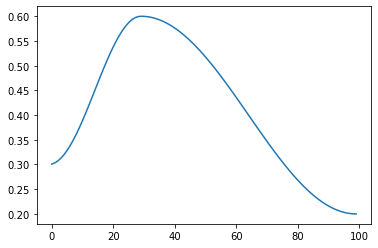

In [19]:
plt.plot(a, [sched(o) for o in p])

We can combine the callback functions in a list and pass it to a `Runner` instance.

In [20]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [21]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [22]:
run.fit(3, learn)

train: [0.7918790625, tensor(0.7799)]
valid: [0.318653076171875, tensor(0.9073)]
train: [0.30302888671875, tensor(0.9118)]
valid: [0.2385738525390625, tensor(0.9336)]
train: [0.24192525390625, tensor(0.9319)]
valid: [0.215330419921875, tensor(0.9416)]


... then check with our recorder if the learning rate followed the right schedule.

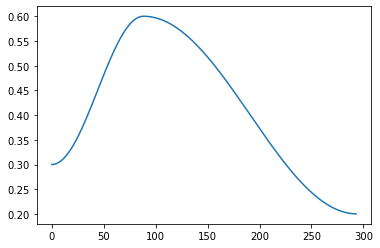

In [23]:
run.recorder.plot_lr()

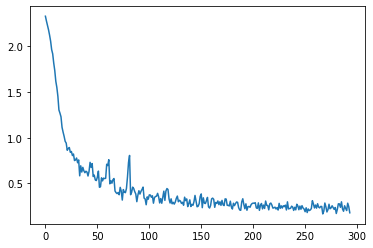

In [24]:
run.recorder.plot_loss()

We have seen how to add callbacks at different stages of the training loop, but one thing we cannot do is adding callbacks *between layers*. Next week we will first add them manually, and then we will take advantage of PyTorch hooks to plot and understand what happens inside our models while they are training, and we will find ways to train them more efficiently.

## Export

In [25]:
!./notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to exp/nb_05.py
